Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


# Model Interpretation 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make a Shapley force plot to explain at least 1 individual prediction.
- [ ] Share at least 1 visualization (of any type) on Slack.

But, if you aren't ready to make a Shapley force plot with your own dataset today, that's okay. You can practice this objective with another dataset instead. You may choose any dataset you've worked with previously.

## Stretch Goals
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!


## Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
import pandas as pd
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.graph_objs as go
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
import shap

In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/VeraMendes/Project---Train-a-predictive-model/master/led.csv')
print(df.shape)

(2938, 22)


In [4]:
# changing my column names
df = df.rename(columns = {
    'Country':'country','Year':'year', 'Status':'development','Lifeexpectancy':'lifespan',
    'AdultMortality':'adult_mortality', 'infantdeaths':'infant_deaths',
    'Alcohol':'alcohol_consumption', 'percentageexpenditure':'percentage_expenditure',
    'HepatitisB':'hepatitisb','Measles':'measles','BMI':'BMI','under-fivedeaths':'baby_deaths',
    'Polio':'polio', 'Totalexpenditure':'total_expenditure','Diphtheria':'diphtheria','HIV/AIDS':'HIV',
    'GDP':'GDP','Population':'population','thinness1-19years':'thinness_teenager',
    'thinness5-9years':'thinness_children','Incomecompositionofresources':'ICR','Schooling':'education'
})

df.head()

,country,year,development,lifespan,adult_mortality,infant_deaths,alcohol_consumption,percentage_expenditure,hepatitisb,measles,...,polio,total_expenditure,diphtheria,HIV,GDP,population,thinness_teenager,thinness_children,ICR,education
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [5]:
# dropping nan's for lifespan
df = df.dropna(axis=0, subset=['lifespan'])
# checking dimnesions of my df
df.shape
# due to leakage problems, I am creating a new column which is going to be my y_target: next_year_lifespan
df['next_year_lifespan']= df['lifespan'].shift(1)
# 2015 does not have data on y_target for any country
# With pd.shift, I have moved into 2015 wrong values for the countries considered.
year_2015 = df[df.year == 2015]
# For my analysis I am dropping 2015 rows to avoid errors and leakage.
df = df[df.year != 2015]
df.head()

,country,year,development,lifespan,adult_mortality,infant_deaths,alcohol_consumption,percentage_expenditure,hepatitisb,measles,...,total_expenditure,diphtheria,HIV,GDP,population,thinness_teenager,thinness_children,ICR,education,next_year_lifespan
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,65.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.9
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2,59.2


In [6]:
# splitting my data into a time series manner
train = df[df['year']<2011]
val = df[(df.year == 2011) | (df.year == 2012)]
test = df[(df.year == 2013) | (df.year == 2014)]
train.shape, val.shape, test.shape

((2013, 23), (366, 23), (366, 23))

In [7]:
# looking into nan's
df.isnull().sum()

country                     0
year                        0
development                 0
lifespan                    0
adult_mortality             0
infant_deaths               0
alcohol_consumption        16
percentage_expenditure      0
hepatitisb                544
measles                     0
BMI                        30
baby_deaths                 0
polio                      19
total_expenditure          45
diphtheria                 19
HIV                         0
GDP                       414
population                603
thinness_teenager          30
thinness_children          30
ICR                       150
education                 150
next_year_lifespan          0
dtype: int64

In [8]:
# Arrange data into X features matrix and y target vector
target = 'next_year_lifespan'
baseline_values = 'lifespan'
cols_to_drop = ['next_year_lifespan']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [9]:
# using previous year lifespan, as y_pred = y_baseline
y_baseline = pd.Series(train['lifespan'], index=train.index)
# using previous year lifespan, as y_pred = y_baseline to try to find a better model fit
mean_baseline = train['next_year_lifespan'].mean()
y_pred = val['lifespan']
baseline_mae = mean_absolute_error(y_val, y_pred)
print('mean baseline:', train['next_year_lifespan'].mean())
print(f'Mean Absolut Error of the baseline prediction (predict lifespan for years 2011 & 2012): {baseline_mae:.4f}')

mean baseline: 68.68564331843021
Mean Absolut Error of the baseline prediction (predict lifespan for years 2011 & 2012): 0.8281


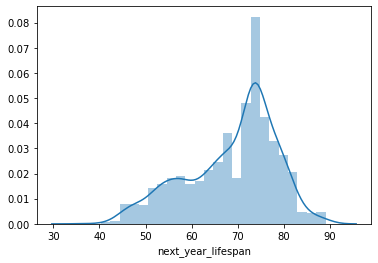

In [173]:
sns.distplot(y_train);

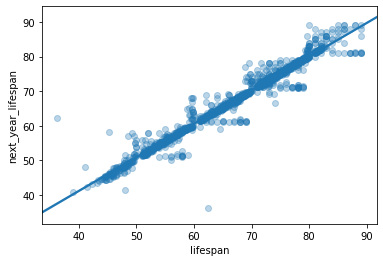

In [174]:
sns.regplot(x=train['lifespan'],y=train['next_year_lifespan'], scatter_kws={'alpha':0.3});

In [175]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [176]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 0.826355152318975


In [177]:
model = Ridge()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 0.8263871477443733


In [178]:
model = DecisionTreeRegressor()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 1.2928961748633878


In [179]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 0.9139125683060093


In [180]:
eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBRegressor(
    n_estimators=3000,
    max_depth=6,       
    learning_rate=0.15, 
    n_jobs=-1
)

model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=50)

[16:09:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:57.9859	validation_1-mae:60.0581
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:49.3087	validation_1-mae:51.156
[2]	validation_0-mae:41.9332	validation_1-mae:43.509
[3]	validation_0-mae:35.6608	validation_1-mae:37.0635
[4]	validation_0-mae:30.324	validation_1-mae:31.5818
[5]	validation_0-mae:25.7884	validation_1-mae:26.8607
[6]	validation_0-mae:21.9366	validation_1-mae:22.8396
[7]	validation_0-mae:18.6582	validation_1-mae:19.4424
[8]	validation_0-mae:15.872	validation_1-mae:16.5621
[9]	validation_0-mae:13.5028	validation_1-mae:14.1054
[10]	validation_0-mae:11.4887	validation_1-mae:12.0057
[11]	validation_0-mae:9.77515	validation_1-mae:10.2262
[12]	validation_0-mae:8.32083	validation_1-mae:8.72382
[13]	validation_0-mae:7.08

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [181]:
# choosing different X features matrix & defining my y target vector
target = 'next_year_lifespan'
cols_to_drop = ['next_year_lifespan', 'year', 'thinness_teenager', 'diphtheria', 'GDP', 'infant_deaths']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [182]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [183]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 0.8028186760262161


In [184]:
model = Ridge()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 0.8028351118329115


In [185]:
model = RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=-1)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 0.868508105522531


In [186]:
eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBRegressor(
    n_estimators=2000,
    max_depth=2,       
    learning_rate=0.025, 
    n_jobs=-1
)

model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=50)

[16:10:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:66.4843	validation_1-mae:68.8232
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:64.8253	validation_1-mae:67.1162
[2]	validation_0-mae:63.2078	validation_1-mae:65.4567
[3]	validation_0-mae:61.6306	validation_1-mae:63.8288
[4]	validation_0-mae:60.0928	validation_1-mae:62.2523
[5]	validation_0-mae:58.5934	validation_1-mae:60.7153
[6]	validation_0-mae:57.1315	validation_1-mae:59.2147
[7]	validation_0-mae:55.7058	validation_1-mae:57.7562
[8]	validation_0-mae:54.3157	validation_1-mae:56.3368
[9]	validation_0-mae:52.9602	validation_1-mae:54.9523
[10]	validation_0-mae:51.6386	validation_1-mae:53.5936
[11]	validation_0-mae:50.3502	validation_1-mae:52.268
[12]	validation_0-mae:49.0939	validation_1-mae:50.9802
[13]	validation_0-mae:4

[144]	validation_0-mae:2.02814	validation_1-mae:2.11553
[145]	validation_0-mae:1.99036	validation_1-mae:2.07459
[146]	validation_0-mae:1.95374	validation_1-mae:2.03496
[147]	validation_0-mae:1.91788	validation_1-mae:1.99613
[148]	validation_0-mae:1.88213	validation_1-mae:1.95904
[149]	validation_0-mae:1.84853	validation_1-mae:1.92286
[150]	validation_0-mae:1.81596	validation_1-mae:1.88726
[151]	validation_0-mae:1.78428	validation_1-mae:1.85267
[152]	validation_0-mae:1.75351	validation_1-mae:1.81922
[153]	validation_0-mae:1.72263	validation_1-mae:1.78673
[154]	validation_0-mae:1.69371	validation_1-mae:1.75489
[155]	validation_0-mae:1.66492	validation_1-mae:1.72334
[156]	validation_0-mae:1.63789	validation_1-mae:1.69215
[157]	validation_0-mae:1.61091	validation_1-mae:1.66236
[158]	validation_0-mae:1.5841	validation_1-mae:1.63404
[159]	validation_0-mae:1.55882	validation_1-mae:1.60611
[160]	validation_0-mae:1.5344	validation_1-mae:1.57883
[161]	validation_0-mae:1.51033	validation_1-mae:1.

[288]	validation_0-mae:0.807727	validation_1-mae:0.827728
[289]	validation_0-mae:0.807231	validation_1-mae:0.828279
[290]	validation_0-mae:0.806891	validation_1-mae:0.828043
[291]	validation_0-mae:0.806533	validation_1-mae:0.827636
[292]	validation_0-mae:0.80631	validation_1-mae:0.827433
[293]	validation_0-mae:0.806004	validation_1-mae:0.827257
[294]	validation_0-mae:0.805566	validation_1-mae:0.827228
[295]	validation_0-mae:0.805126	validation_1-mae:0.826834
[296]	validation_0-mae:0.80492	validation_1-mae:0.826653
[297]	validation_0-mae:0.804685	validation_1-mae:0.826702
[298]	validation_0-mae:0.804433	validation_1-mae:0.826747
[299]	validation_0-mae:0.804136	validation_1-mae:0.826578
[300]	validation_0-mae:0.803846	validation_1-mae:0.826713
[301]	validation_0-mae:0.803653	validation_1-mae:0.826558
[302]	validation_0-mae:0.803457	validation_1-mae:0.826114
[303]	validation_0-mae:0.803179	validation_1-mae:0.825954
[304]	validation_0-mae:0.803029	validation_1-mae:0.82587
[305]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.025, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [187]:
df.columns

Index(['country', 'year', 'development', 'lifespan', 'adult_mortality',
       'infant_deaths', 'alcohol_consumption', 'percentage_expenditure',
       'hepatitisb', 'measles', 'BMI', 'baby_deaths', 'polio',
       'total_expenditure', 'diphtheria', 'HIV', 'GDP', 'population',
       'thinness_teenager', 'thinness_children', 'ICR', 'education',
       'next_year_lifespan'],
      dtype='object')

In [188]:
# choosing different X features matrix & defining my y target vector
target = 'next_year_lifespan'
cols_to_drop = ['country', 'year', 'development','infant_deaths',
                'percentage_expenditure','hepatitisb', 'measles',
                'polio','total_expenditure', 'diphtheria', 'GDP',
                'population', 'thinness_teenager', 'next_year_lifespan']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [189]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [190]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 0.7694277849740445


In [191]:
eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBRegressor(
    n_estimators=2000,
    max_depth=3,       
    learning_rate=0.025, 
    n_jobs=-1
)

model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=50)

[16:10:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:66.4857	validation_1-mae:68.8234
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:64.8282	validation_1-mae:67.115
[2]	validation_0-mae:63.212	validation_1-mae:65.4453
[3]	validation_0-mae:61.636	validation_1-mae:63.8248
[4]	validation_0-mae:60.0994	validation_1-mae:62.2407
[5]	validation_0-mae:58.6011	validation_1-mae:60.692
[6]	validation_0-mae:57.1394	validation_1-mae:59.1864
[7]	validation_0-mae:55.7149	validation_1-mae:57.7229
[8]	validation_0-mae:54.3255	validation_1-mae:56.2955
[9]	validation_0-mae:52.9711	validation_1-mae:54.9035
[10]	validation_0-mae:51.65	validation_1-mae:53.5409
[11]	validation_0-mae:50.3624	validation_1-mae:52.215
[12]	validation_0-mae:49.1068	validation_1-mae:50.923
[13]	validation_0-mae:47.8821	

[145]	validation_0-mae:1.93756	validation_1-mae:2.02976
[146]	validation_0-mae:1.89967	validation_1-mae:1.99094
[147]	validation_0-mae:1.86256	validation_1-mae:1.95284
[148]	validation_0-mae:1.82714	validation_1-mae:1.91445
[149]	validation_0-mae:1.79198	validation_1-mae:1.87802
[150]	validation_0-mae:1.75838	validation_1-mae:1.84292
[151]	validation_0-mae:1.72515	validation_1-mae:1.80836
[152]	validation_0-mae:1.69363	validation_1-mae:1.77504
[153]	validation_0-mae:1.66304	validation_1-mae:1.74158
[154]	validation_0-mae:1.63271	validation_1-mae:1.711
[155]	validation_0-mae:1.6029	validation_1-mae:1.68042
[156]	validation_0-mae:1.57478	validation_1-mae:1.64976
[157]	validation_0-mae:1.54717	validation_1-mae:1.62085
[158]	validation_0-mae:1.51987	validation_1-mae:1.59231
[159]	validation_0-mae:1.49406	validation_1-mae:1.56413
[160]	validation_0-mae:1.46824	validation_1-mae:1.5373
[161]	validation_0-mae:1.44364	validation_1-mae:1.51168
[162]	validation_0-mae:1.42018	validation_1-mae:1.48

[289]	validation_0-mae:0.733082	validation_1-mae:0.806724
[290]	validation_0-mae:0.73291	validation_1-mae:0.806515
[291]	validation_0-mae:0.732755	validation_1-mae:0.806598
[292]	validation_0-mae:0.732634	validation_1-mae:0.806863
[293]	validation_0-mae:0.732455	validation_1-mae:0.806999
[294]	validation_0-mae:0.731904	validation_1-mae:0.806533
[295]	validation_0-mae:0.731579	validation_1-mae:0.806359
[296]	validation_0-mae:0.731163	validation_1-mae:0.806398
[297]	validation_0-mae:0.730897	validation_1-mae:0.806022
[298]	validation_0-mae:0.730546	validation_1-mae:0.805979
[299]	validation_0-mae:0.730029	validation_1-mae:0.805582
[300]	validation_0-mae:0.729719	validation_1-mae:0.805437
[301]	validation_0-mae:0.729571	validation_1-mae:0.805536
[302]	validation_0-mae:0.729172	validation_1-mae:0.80566
[303]	validation_0-mae:0.729013	validation_1-mae:0.805547
[304]	validation_0-mae:0.728874	validation_1-mae:0.805647
[305]	validation_0-mae:0.728478	validation_1-mae:0.805794
[306]	validation

[431]	validation_0-mae:0.698938	validation_1-mae:0.803375
[432]	validation_0-mae:0.69878	validation_1-mae:0.80334
[433]	validation_0-mae:0.698683	validation_1-mae:0.803716
[434]	validation_0-mae:0.69856	validation_1-mae:0.803693
[435]	validation_0-mae:0.698379	validation_1-mae:0.803525
[436]	validation_0-mae:0.698232	validation_1-mae:0.803491
[437]	validation_0-mae:0.698055	validation_1-mae:0.80371
[438]	validation_0-mae:0.697872	validation_1-mae:0.803701
[439]	validation_0-mae:0.697625	validation_1-mae:0.803402
[440]	validation_0-mae:0.697493	validation_1-mae:0.803529
[441]	validation_0-mae:0.697319	validation_1-mae:0.803364
[442]	validation_0-mae:0.697059	validation_1-mae:0.803267
[443]	validation_0-mae:0.696765	validation_1-mae:0.802989
[444]	validation_0-mae:0.696647	validation_1-mae:0.802983
[445]	validation_0-mae:0.696478	validation_1-mae:0.803075
[446]	validation_0-mae:0.696058	validation_1-mae:0.803077
[447]	validation_0-mae:0.695803	validation_1-mae:0.802983
[448]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.025, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [10]:
# choosing different X features matrix & defining my y target vector
target = 'next_year_lifespan'
cols_to_drop = ['country', 'year', 'development',
       'infant_deaths', 'alcohol_consumption', 'percentage_expenditure',
       'hepatitisb', 'measles', 'BMI', 'baby_deaths', 'polio',
       'total_expenditure', 'diphtheria', 'GDP', 'population',
       'thinness_teenager', 'thinness_children', 'education',
       'next_year_lifespan']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [11]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [12]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 0.744710423837991


In [195]:
eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBRegressor(
    n_estimators=2000,
    max_depth=3,       
    learning_rate=0.025, 
    n_jobs=-1
)

model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=50)

[16:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:66.4857	validation_1-mae:68.8234
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:64.8282	validation_1-mae:67.115
[2]	validation_0-mae:63.212	validation_1-mae:65.4453
[3]	validation_0-mae:61.636	validation_1-mae:63.8248
[4]	validation_0-mae:60.0994	validation_1-mae:62.2407
[5]	validation_0-mae:58.6011	validation_1-mae:60.692
[6]	validation_0-mae:57.1394	validation_1-mae:59.1864
[7]	validation_0-mae:55.7149	validation_1-mae:57.7229
[8]	validation_0-mae:54.3255	validation_1-mae:56.2955
[9]	validation_0-mae:52.9711	validation_1-mae:54.9035
[10]	validation_0-mae:51.65	validation_1-mae:53.5409
[11]	validation_0-mae:50.3624	validation_1-mae:52.215
[12]	validation_0-mae:49.1068	validation_1-mae:50.923
[13]	validation_0-mae:47.8821	

[145]	validation_0-mae:1.93455	validation_1-mae:2.00676
[146]	validation_0-mae:1.89701	validation_1-mae:1.96613
[147]	validation_0-mae:1.86049	validation_1-mae:1.92673
[148]	validation_0-mae:1.82446	validation_1-mae:1.88929
[149]	validation_0-mae:1.79017	validation_1-mae:1.8516
[150]	validation_0-mae:1.75688	validation_1-mae:1.81498
[151]	validation_0-mae:1.7244	validation_1-mae:1.77991
[152]	validation_0-mae:1.69225	validation_1-mae:1.74645
[153]	validation_0-mae:1.66162	validation_1-mae:1.71334
[154]	validation_0-mae:1.63183	validation_1-mae:1.68117
[155]	validation_0-mae:1.60299	validation_1-mae:1.64945
[156]	validation_0-mae:1.57429	validation_1-mae:1.61968
[157]	validation_0-mae:1.54626	validation_1-mae:1.59014
[158]	validation_0-mae:1.51962	validation_1-mae:1.56096
[159]	validation_0-mae:1.49323	validation_1-mae:1.53369
[160]	validation_0-mae:1.46764	validation_1-mae:1.50671
[161]	validation_0-mae:1.4428	validation_1-mae:1.48077
[162]	validation_0-mae:1.41913	validation_1-mae:1.4

[289]	validation_0-mae:0.747377	validation_1-mae:0.778453
[290]	validation_0-mae:0.746974	validation_1-mae:0.777917
[291]	validation_0-mae:0.746824	validation_1-mae:0.77816
[292]	validation_0-mae:0.746489	validation_1-mae:0.777783
[293]	validation_0-mae:0.746342	validation_1-mae:0.777901
[294]	validation_0-mae:0.746046	validation_1-mae:0.77785
[295]	validation_0-mae:0.745724	validation_1-mae:0.777678
[296]	validation_0-mae:0.745441	validation_1-mae:0.777713
[297]	validation_0-mae:0.745264	validation_1-mae:0.777723
[298]	validation_0-mae:0.744942	validation_1-mae:0.777453
[299]	validation_0-mae:0.744666	validation_1-mae:0.777402
[300]	validation_0-mae:0.744392	validation_1-mae:0.777283
[301]	validation_0-mae:0.74421	validation_1-mae:0.777588
[302]	validation_0-mae:0.743893	validation_1-mae:0.777163
[303]	validation_0-mae:0.743601	validation_1-mae:0.776606
[304]	validation_0-mae:0.743346	validation_1-mae:0.776642
[305]	validation_0-mae:0.74316	validation_1-mae:0.776654
[306]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.025, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [13]:
model = RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=-1)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 0.8437932008288056


In [14]:
X_train.columns

Index(['lifespan', 'adult_mortality', 'HIV', 'ICR'], dtype='object')

In [15]:
X_train.describe()

,lifespan,adult_mortality,HIV,ICR
count,2013.000000,2013.000000,2013.000000,1903.000000
mean,68.330750,171.008942,2.165574,0.601809
std,9.823112,131.428222,5.966201,0.227761
min,36.300000,1.000000,0.100000,0.000000
25%,62.000000,76.000000,0.100000,0.465000
50%,71.700000,146.000000,0.100000,0.659000
75%,75.000000,234.000000,1.100000,0.764000
max,89.000000,723.000000,50.600000,0.936000


In [24]:
mae = mean_absolute_error(y_val, y_pred)
def predict(lifespan, adult_mortality, HIV, ICR):
    df1 = pd.DataFrame(
        data=[[lifespan, adult_mortality, HIV, ICR]], 
        columns=['lifespan', 'adult_mortality', 'HIV', 'ICR']
    )
    pred = model.predict(df1)[0]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df1)
    
    feature_names = df1.columns
    feature_values = df1.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    
    result = f'Life expectancy is expected to be {pred:,.2f} considering lifespan, adult_mortality, HIV, ICR for previous year. \n\n'
    result += f'Starting from a baseline of {explainer.expected_value:,.2f} and an absolut error of {mae:,.2f}\n'
    result += shaps.to_string()
    print(result)

In [25]:
predict(lifespan=70, adult_mortality=200, HIV=3, ICR=0.7)

Life expectancy is expected to be 72.55 considering lifespan, adult_mortality, HIV, ICR for previous year. 

Starting from a baseline of 68.70 and an absolut error of 0.84
(lifespan, 70.0)            3.946807
(adult_mortality, 200.0)   -0.084913
(HIV, 3.0)                 -0.017207
(ICR, 0.7)                  0.007988
